In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score
from sklearn.metrics import recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/RyanHinshaw/"
 + "csc442_group_project/refs/heads/main/datasets/merged_player_data.csv")
df = df.sort_values(by='pts', ascending=False).reset_index(drop=True)
df['draft_number'] = pd.to_numeric(df['draft_number'], errors='coerce')
df['lottery_pick'] = df['draft_number'] <= 14
df['POS'] = df['POS'].str.split('-').str[0]
df['POS'] = df.POS.astype('category')
df = pd.get_dummies(df, columns=['POS'])
query_df = df[['player_name', 'lottery_pick', 'player_height',
               'STNDVERT', 'LPVERT', 'LANE', 'SPRINT',
               'POS_PG', 'POS_SG', 'POS_SF', 'POS_PF', 'POS_C']]
query_df

,player_name,lottery_pick,player_height,STNDVERT,LPVERT,LANE,SPRINT,POS_PG,POS_SG,POS_SF,POS_PF,POS_C
0,James Harden,True,77.0,31.5,37.0,11.10,3.13,False,True,False,False,False
1,Damian Lillard,True,74.0,34.5,39.5,11.15,3.34,True,False,False,False,False
2,Kevin Durant,True,81.0,26.0,33.5,12.33,3.45,False,False,True,False,False
3,Stephen Curry,True,75.0,29.5,35.5,11.07,3.28,True,False,False,False,False
4,Russell Westbrook,True,75.0,30.0,36.5,10.98,3.08,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
979,Darius Johnson-Odom,False,74.0,33.5,41.5,10.76,3.21,False,True,False,False,False
980,Cat Barber,False,73.0,NaN,NaN,NaN,NaN,True,False,False,False,False
981,Chris McCray,False,77.0,30.5,39.0,11.46,3.34,False,True,False,False,False
982,Michael Foster Jr.,False,80.0,28.0,32.5,11.49,3.22,False,False,False,False,True


In [3]:
# Set X as the independent variables and Y as the response variable
X = query_df[['player_height', 'POS_PG', 'POS_SG', 'POS_SF',
              'POS_PF', 'POS_C', 'STNDVERT', 'LPVERT','LANE', 'SPRINT']]
y = query_df['lottery_pick']

# Split player data into training and testing (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    random_state=42)

# Create and fit random forest model, balancing each column/class weight
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Get predicted probabilities for class=True (lottery pick or not)
y_proba = rf.predict_proba(X_test)[:, 1]

# Lowered acceptance threshold to allow model to predict more lottery picks
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluate results
print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall:", recall_score(y_test, y_pred_thresh))
print("F1 Score:", f1_score(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))

Precision: 0.24468085106382978
Recall: 0.40350877192982454
F1 Score: 0.304635761589404
              precision    recall  f1-score   support

       False       0.83      0.70      0.76       239
        True       0.24      0.40      0.30        57

    accuracy                           0.65       296
   macro avg       0.54      0.55      0.53       296
weighted avg       0.72      0.65      0.67       296



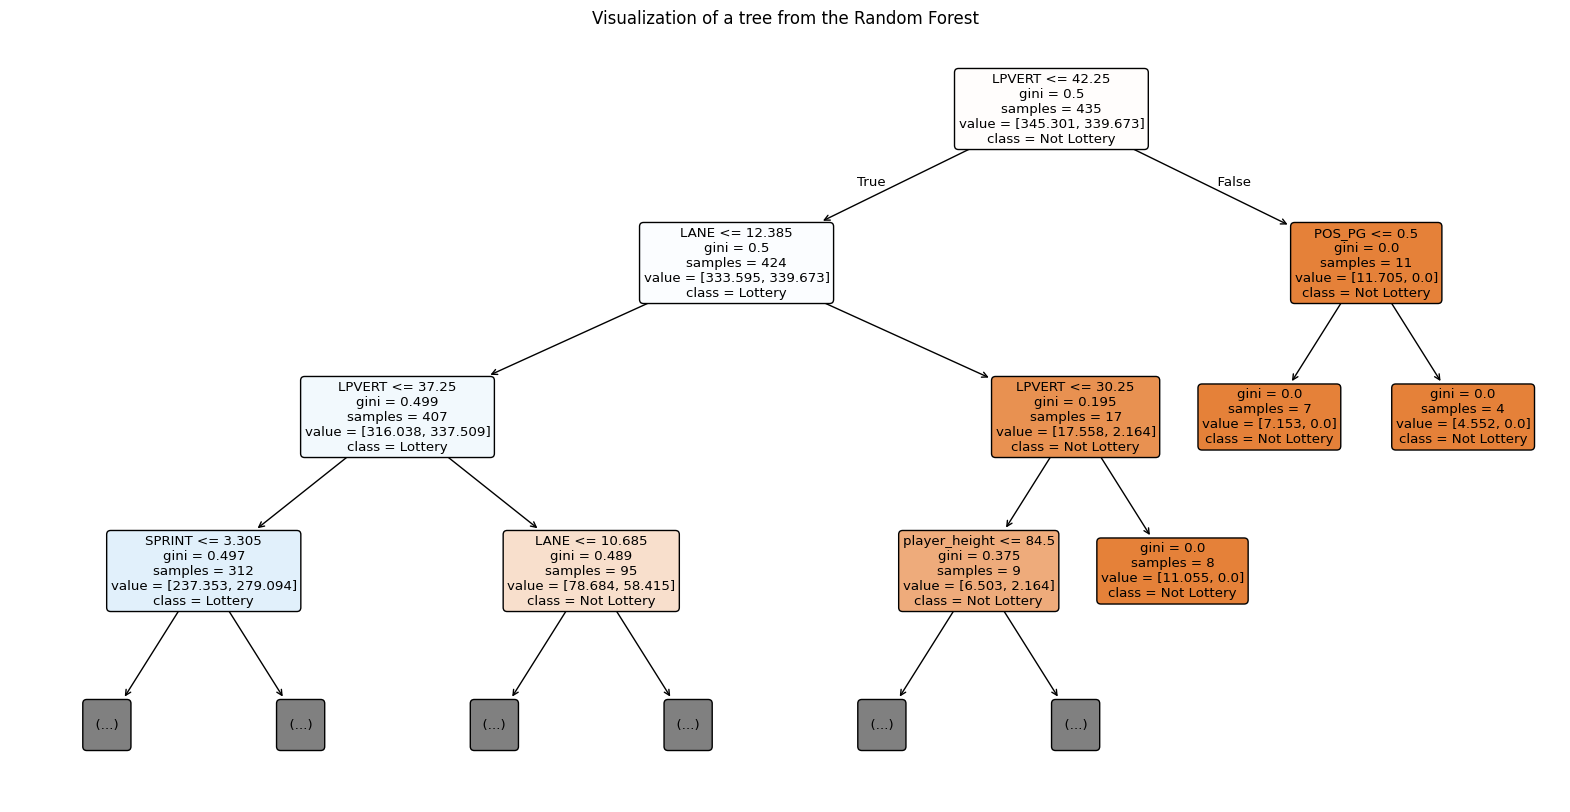

In [4]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pick one tree from the forest (e.g., the first one)
estimator = rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=X.columns,
          class_names=['Not Lottery', 'Lottery'],
          filled=True,
          rounded=True,
          max_depth=3)  # optional: limit depth for readability
plt.title("Visualization of a tree from the Random Forest")
plt.show()